In [90]:
# Import modules
import numpy as np
import pandas as pd 

from scipy.optimize import minimize
from scipy.stats import multivariate_normal, binom 

from functools import partial

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns 

%matplotlib inline 

from IPython.display import HTML

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

from sklearn import datasets
from sklearn.utils import shuffle

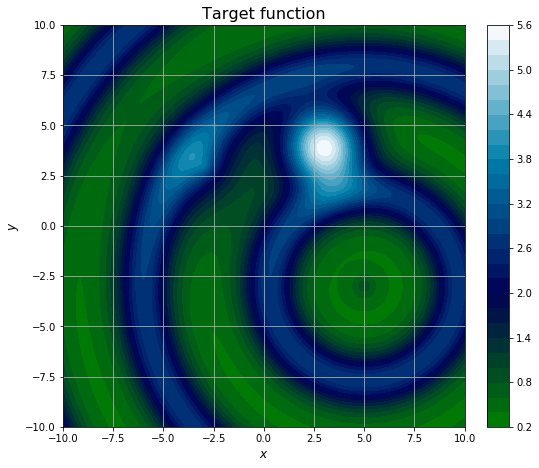

In [91]:
SEED = 21

# Plotting limits
x_limits = (-10, 10)
y_limits = (-10, 10)

# Define a toy problem
fct = lambda x, y: 5*np.exp(-((x - 3)**2 + (y - 4)**2)/4) + \
                   2*np.exp(-np.sqrt((x + 3)**2 + (y - 3)**2)/2) + \
                   1*np.exp(-np.sin(np.sqrt((x - 5)**2 + (y + 3)**2)/1))

# Defining mesh
xy_mesh = np.meshgrid(np.linspace(*x_limits, 2001), np.linspace(*y_limits, 2001))
fct_mesh = fct(xy_mesh[0], xy_mesh[1])

# Plot the function
fig0 = plt.figure(figsize=(8, 8))

cntr = plt.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
_ = fig0.colorbar(cntr, ax=plt.gca(), fraction=0.05, pad=0.05, aspect=18)

plt.xlabel('$x$', fontsize=12)
plt.ylabel('$y$', fontsize=12)
plt.title('Target function', fontsize=16)

plt.gca().grid(True)
plt.gca().set_aspect('equal')

In [92]:
# Grid Search

# Number 
n_pts = 14

# Building GS grid and evaluating function
xy_GS = np.meshgrid(np.linspace(*x_limits, n_pts), np.linspace(*y_limits, n_pts))
fct_GS = fct(xy_GS[0], xy_GS[1])

# Best point obtained by Grid Search
best_GS = (fct_GS.max(), (xy_GS[0].flatten()[fct_GS.argmax()], xy_GS[1].flatten()[fct_GS.argmax()]))


In [93]:
# Random Search
# Setting up random seed for reproducibility
np.random.seed(SEED)

# Sampling points from prior distribution for x and y
y_std = 5
xy_RS = [np.random.uniform(*x_limits, n_pts**2).reshape(n_pts, n_pts),
        np.random.normal(0, y_std, n_pts**2).reshape(n_pts, n_pts)]
fct_RS = fct(xy_RS[0], xy_RS[1])

# Best point obtained by Random Search
best_RS = (fct_RS.max(), (xy_RS[0].flatten()[fct_RS.argmax()], xy_RS[1].flatten()[fct_RS.argmax()]))

In [94]:
# Numerical maximization L-BFGS-B
xy_M = [(0.0, 0.0)]

# Function to dump current point in minimization algorithm to list
def f_current_point(x):
    xy_M.append(x)
    return None
    
# Start maximization (minus sign since most optimization problems are formulated in terms of finding minimum)
res_M = minimize(lambda x: -fct(*x), x0=xy_M[0], method='L-BFGS-B',
                bounds=[x_limits, y_limits], options={'maxiter': n_pts**2},
                callback=f_current_point)
print(res_M)

# Best point obtained by L-BFGS-B
xy_M=np.array(xy_M).T
best_M = (-res_M.fun, res_M.x)

      fun: -5.540910223654586
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.24344979e-06, -1.48325796e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 69
      nit: 11
   status: 0
  success: True
        x: array([3.01370178, 3.88382836])


In [95]:
# Hyper-opt

# Set up hyperparameters space
hp_space = {'x': hp.uniform('x', *x_limits),
            'y': hp.normal('y', 0, 5)}

# Set up number of evaluations and Trials object
n_evals = n_pts**2
trls = Trials()

# Run optimization
res_HO = fmin(lambda hps: -fct(hps['x'], hps['y']), space=hp_space, algo=tpe.suggest, 
             trials=trls, max_evals=n_evals, rstate=np.random.RandomState(SEED))

# Restore search history and best point
xy_HO = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
         np.array([x['misc']['vals']['y'] for x in trls.trials])]
best_HO = (-trls.best_trial['result']['loss'], (space_eval(hp_space, res_HO)['x'], 
                                                space_eval(hp_space, res_HO)['y']))

100%|██████████| 196/196 [00:00<00:00, 391.48it/s, best loss: -5.528460905856665]


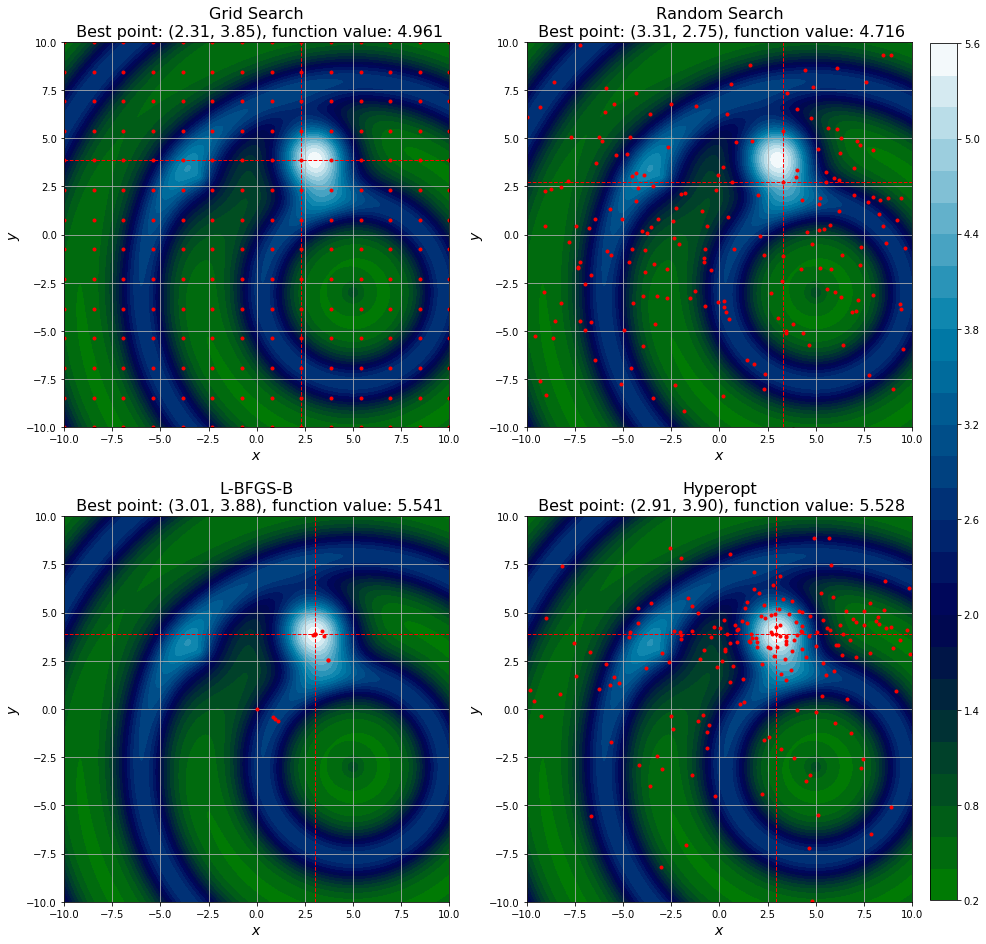

In [96]:
# Set up layout and graph labels
fig0, axs = plt.subplots(nrows=2, ncols=2, figsize = (16, 16))
labels = ('Grid Search', 'Random Search', 'L-BFGS-B', 'Hyperopt')

#Plot
for (xy, xlabel, xbest, ax) in zip((xy_GS, xy_RS, xy_M, xy_HO), 
                            labels,
                            (best_GS, best_RS, best_M, best_HO), 
                            axs.flatten()):
    # Function contour and points from search history
    cntr = ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    ax.plot(xy[0], xy[1], linewidth=0, marker='.', color='red')
    
    # Marking best result
    ax.plot(x_limits, [xbest[1][1]]*2, linewidth=1, linestyle='--', color='red')
    ax.plot([xbest[1][0]]*2, y_limits, linewidth=1, linestyle='--', color='red')
    
    # Formatting axes
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    
    ax.set_xlabel('$x$', fontsize = 14)
    ax.set_ylabel('$y$', fontsize = 14)
    
    ax.set_title('{0}\n Best point: ({1:.2f}, {2:.2f}), function value: {3:.3f}'.format(
        xlabel, *xbest[1], xbest[0]), fontsize=16)
    
    ax.grid(True)
    ax.set_aspect('equal')

# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=32)

In [104]:
steps = 2000

trls = Trials()
trls_random = Trials()

res_RS = fmin(lambda hps: -fct(hps['x'], hps['y']), 
              space = hp_space, algo = tpe.suggest,
              trials=trls, max_evals=steps, rstate=np.random.RandomState(SEED))

xy_HO2 = [np.array([x['misc']['vals']['x'] for x in trls.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls.trials])]

res_RS = fmin(lambda hps: -fct(hps['x'], hps['y']), space = hp_space, algo = tpe.rand.suggest, 
              trials = trls_random, max_evals = steps, rstate = np.random.RandomState(SEED))

xy_RS2 = [np.array([x['misc']['vals']['x'] for x in trls_random.trials]), 
          np.array([x['misc']['vals']['y'] for x in trls_random.trials])]

100%|██████████| 2000/2000 [00:02<00:00, 780.30it/s, best loss: -5.509502038738186]


In [105]:
# Setting up figure
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
labels = ['Random Search', 'Hyperopt']

# Setting up animation frames
n_frames = 20
n_frame_pts = steps//n_frames

# Initial axes formatting
for (ax, xlabel) in zip(axs.flatten(), labels):
    ax.contourf(xy_mesh[0], xy_mesh[1], fct_mesh, levels=30, cmap=plt.cm.ocean)
    
    ax.set_xlim(x_limits)
    ax.set_xlim(y_limits)
    
    ax.set_title(xlabel, fontsize=16)
    
    ax.set_xlabel('$x$', fontsize=14)
    ax.set_ylabel('$y$', fontsize=14)

    ax.grid(True)
    ax.set_aspect('equal')
    
# Adding colorbar
_ = fig0.colorbar(cntr, ax=axs, fraction=0.03, pad=0.02, aspect=15)

# Points and iteration indicator are the only things that change
pts0 = axs[0].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
pts1 = axs[1].plot([], [], linewidth=0, marker='o', color='red', markersize=5)
fig0_tl = fig0.suptitle('Batch {0}'.format(0), fontsize=18)


def f_update_anim(frame, n_frames):
    """
    TODO
    """
    
    # Determine indexes of points within iteration
    idx0 = int(frame*len(trls)/n_frames)
    idx1 = int((frame + 1)*len(trls)/n_frames)
    
    # Plot new data
    pts0[0].set_data(xy_RS2[0][idx0:idx1], xy_RS2[1][idx0:idx1])
    pts1[0].set_data(xy_HO2[0][idx0:idx1], xy_HO2[1][idx0:idx1])
    fig0_tl.set_text('Batch {0}'.format(frame + 1, n_frames))
    
    return pts0[0], pts1[0], fig0_tl

plt.close()

# Set up animation
ani1 = FuncAnimation(fig0, lambda fr: f_update_anim(fr, n_frames), frames=n_frames, interval=500, blit=False)

HTML(ani1.to_jshtml())

